Notebook contains experiments for BCENa loss, which is tweaked BCE loss that takes into account unknown and unseen before categories. Checks whether changing the target vector of an unknown category to an empty vector would be more effective than treating it the same as the others.

# Setup

In [ ]:
! pip install -q fastai2
! pip install -q psutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

# save models on gdrive
path = Path('/content/drive/My Drive/')
assert path.is_dir()

# save models in local folder
# path = Path('.').resolve()

# Modified loss and accuracies

In [ ]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.distributed import *
from fastai2.optimizer import *

## accuracy metrics

metrics that are taking into account that first category is unknown

1. **accuracy_with_na** count accuracy, but all values below threshold treat as unknown caegory
1. **accuracy_without_na** count accuracy ommiting unknown category

In [ ]:
class SkipMetricPartException(Exception):
  pass

class AvgPartMetric(AvgMetric):
  "Average the values of `func` allowing to raise exception and omit accumulation"
  def accumulate(self, learn):
    try:
      val, bs = self.func(learn.pred, *learn.yb)
      self.total += to_detach(val)*bs
      self.count += bs
    except SkipMetricPartException: pass
    except Exception as e: print(e)

def accuracy_with_na(inp, targ, thresh=0.4, na_idx=0, axis=-1, sigmoid=True):
  "Compute accuracy assuming that prediction below threshold belongs to first category (#na#)"
  if sigmoid: inp = inp.sigmoid()
  valm, argm = inp.max(dim=axis)
  argm[valm < thresh] = na_idx # treat all values below threshold as category #na#
  inp, targ = flatten_check(argm, targ)
  return (inp==targ).float().mean()

def _accuracy_without_na(inp, targ, na_idx=0, axis=-1):
  "Compute accuracy with `targ` when `pred` omiting #na# category"
  idxs = targ!=na_idx
  if idxs.any():
    inp, targ = flatten_check(inp[idxs].argmax(dim=axis), targ[idxs])
    return (inp==targ).float().mean(), targ.shape[axis]
  else:
    # skip accumulating metric if there is only category #na# in batch
    raise SkipMetricPartException

_accuracy_without_na.__name__ = 'accuracy_without_na'
accuracy_without_na = AvgPartMetric(_accuracy_without_na)

## bce na losses

BCENaLoss - BCE loss that is changing the target vector of an unknown category to an empty vector

In [ ]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from torch import nn

class BCENaLoss(nn.Module):
  y_int = True

  def __init__(self, logits=True, reduction='mean'):
    super().__init__()
    self.reduction = reduction
    self.logits = logits

  def forward(self, input, target):
    target = F.one_hot(target, input.shape[1]).float()
    target[:, 0] = 0 # first category is #na# category so it should be zeroed
    if self.logits:
      return F.binary_cross_entropy_with_logits(input, target, reduction=self.reduction) # sigmoid + bce
    else:
      return F.binary_cross_entropy(input, target, reduction=self.reduction) # no sigmoid


@delegates(keep=True)
class BCENaLossFlat(BaseLoss):
  "Same as `FocalLoss`, but flattens input and target."
  def __init__(self, *args, axis=-1, thresh=0.5, **kwargs):
    super().__init__(BCENaLoss, *args, axis=axis, **kwargs)
    self.thresh = thresh

  def decodes(self, x):
    valm, argm = x.max(dim=self.axis)
    argm[valm < self.thresh] = 0
    return argm

  def activation(self, x): return torch.sigmoid(x)


In [ ]:
@delegates()
class BCEWithLogitsLossOneHotFlat(BCEWithLogitsLossFlat):
  def __call__(self, inp, targ, **kwargs):
    return super().__call__(inp, F.one_hot(targ, inp.shape[1]), **kwargs)
  def decodes(self, x):    return x.argmax(dim=-1)
  def activation(self, x): return torch.sigmoid(x)

# Dataloaders

Three types of categories are considered.

<i>Known</i> categories &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- network recognises and can be returned as a prediction<br>
<i>Unknown</i> categories &nbsp;- may be (depends on add_na parameter) trained and recognized by network, but all falls into category <b>#na#</b><br>
<i>Unseen</i> categories &nbsp;&nbsp;&nbsp;&nbsp;- are not trained and are not seen before validation

training and validation set contain known (and depends on <i>add_na</i> parameter) and unknown categories<br>
test set contains always known, unknown and unseen categories

In [ ]:
def get_train_dls(bs=48, size=128, workers=None, augs=True, item_tfms=[], batch_tfms=[], add_na=False, train_na=None):
  dspath = untar_data(URLs.IMAGENETTE_160)

  if workers is None: workers = min(8, num_cpus()//(num_distrib() or 1))
  norm_tfms = [Normalize.from_stats(*imagenet_stats)]
  resize_tfms = [Resize(size, method=ResizeMethod.Pad, pad_mode=PadMode.Reflection)]
  augs_tfms = aug_transforms() if augs else []

  # categories known and trained
  train_cats = [
    'n03417042',
    'n02979186',
    'n03394916',
    'n03445777',
  ]

  # categories na and trained
  na_train_cats = [
    'n03028079',
    'n01440764',
    'n03888257',
  ]

  # categories not trained (unseen by network)
  test_cats = [
    'n02102040',
    'n03000684',
    'n03425413'               
  ]

  if train_na is None: train_na = add_na

  def get_items(dspath):
    if train_na:
      # train and validate known and unknown categories
      train_folders = train_cats + na_train_cats
      valid_folders = train_cats + na_train_cats
    else:
      # train and validate only known categories
      train_folders = train_cats
      valid_folders = train_cats

    return get_image_files(dspath/'train', folders=train_folders) + get_image_files(dspath/'val', folders=valid_folders)

  # create train and valid dataloaders
  dbl = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=train_cats, add_na=add_na)),
    get_items=get_items,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    item_tfms=item_tfms + resize_tfms,
    batch_tfms=batch_tfms + augs_tfms + norm_tfms,
  )

  dls = dbl.dataloaders(dspath, bs=bs, num_workers=workers)

  if not add_na:
    # support any unknown category as random from existing categories
    # it does not affect training, only enables validation for not known categories
    items = dls.valid.tfms[1][1].vocab.items
    o2i = dls.valid.tfms[1][1].vocab.o2i
    dls.valid.tfms[1][1].vocab.o2i = defaultdict(lambda: random.randint(0, len(items) - 1), o2i)

  # add custom test dataloader to validate all cats (even unseen before)
  test_items = get_image_files(dspath, folders=['val'])
  dls.test = dls.test_dl(test_items, with_labels=True)

  return dls

dataset with only known categories

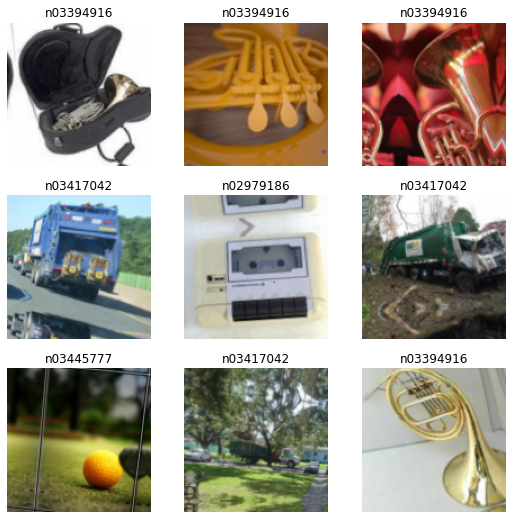

In [ ]:
dls = get_train_dls()
dls.show_batch()

dataset with known and unknown (labeled as #na#) categories

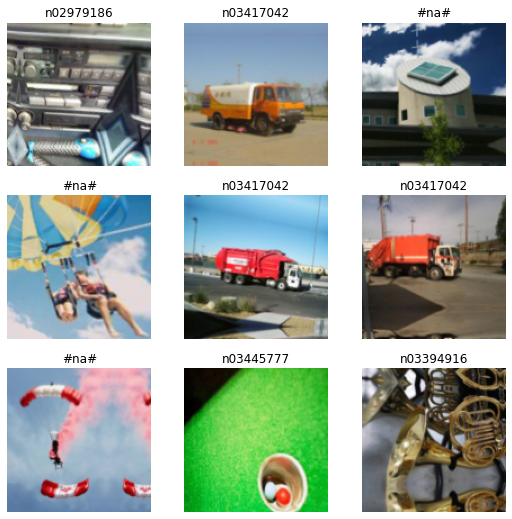

In [ ]:
dls = get_train_dls(add_na=True)
dls.show_batch()

dataset with known, unknown and unseen categories

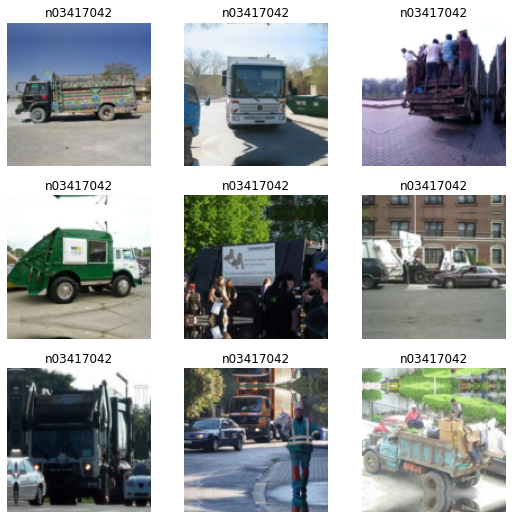

In [ ]:
dls.test.show_batch()

# 1. Train - BCE 

Basic single-label classification but with BCE (sigmoid + CE) instead of categorical CE (softmax + CE) as a loss function


epoch,train_loss,valid_loss,accuracy,time
0,0.685283,0.423040,0.764133,00:15
1,0.453100,0.307043,0.790123,00:14


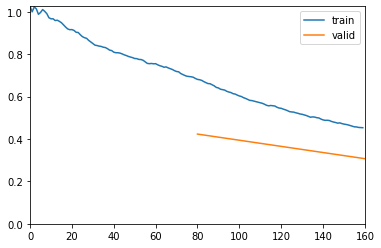

epoch,train_loss,valid_loss,accuracy,time
0,0.310471,0.240303,0.815465,00:15
1,0.287221,0.226851,0.827810,00:15
2,0.269721,0.213186,0.831059,00:15
3,0.259725,0.218911,0.843405,00:15
4,0.240589,0.202199,0.845354,00:15
5,0.227741,0.200551,0.833008,00:15
6,0.212560,0.198160,0.853801,00:15
7,0.209340,0.186817,0.854451,00:15
8,0.186275,0.175452,0.861598,00:15
9,0.180024,0.180317,0.864847,00:15


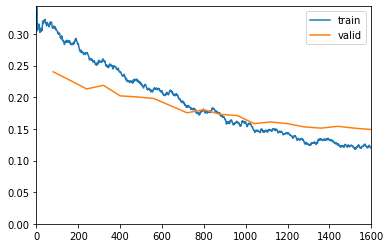

In [ ]:
learn = cnn_learner(
  get_train_dls(), xresnet18, pretrained=True,
  loss_func=BCEWithLogitsLossOneHotFlat(),
  metrics=[accuracy],
  path=path,
  cbs=[ShowGraphCallback]
)

if torch.cuda.is_available(): learn = learn.to_fp16()

learn.fine_tune(20, freeze_epochs=2)

# Validate - BCE

Accuracy for known categories is near 90% <i>(first graph)</i>

When I pass pictures from unknown categories, accuracy becomes a mess and shows that true accuracy<br> is much worse.

Accuracy for known and unknown categories shows about 50% <i>(second graph)</i>

It really depends how much unseen pictures were passed into network during validation.<br> Real accuracy is even worse then this, because for unknown picture network has choosen<br> random category, but shouldn't choose at all.

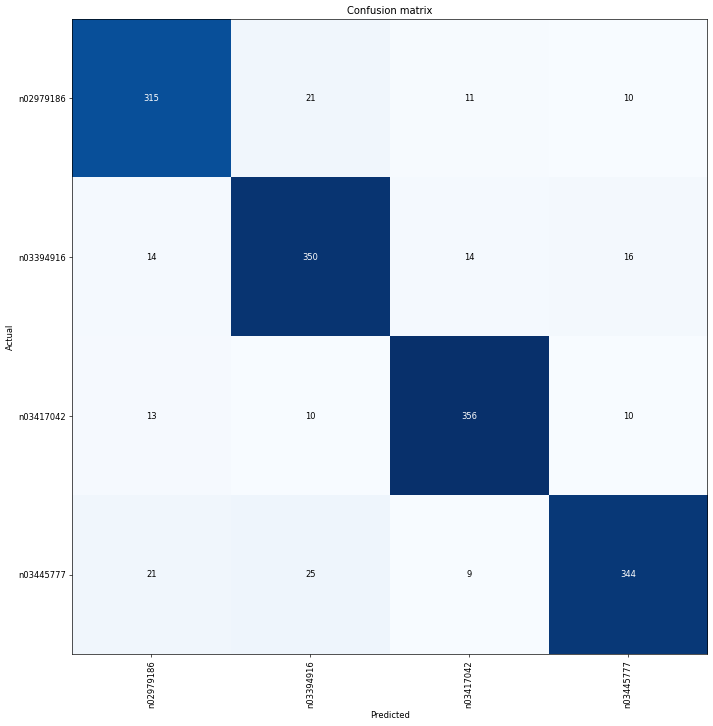

In [ ]:
# confusion_matrix for known categories
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.remove_cb(ShowGraphCallback) # fix fastai callback error during validation
v_loss, v_accuracy = learn.validate(dl=learn.dls.test) # validate with all known, unknown and unseen categories

print(f'validation loss: {v_loss}, [accuracy]: {v_accuracy}')

validation loss: 0.7358161211013794, [accuracy]: 0.48662421107292175


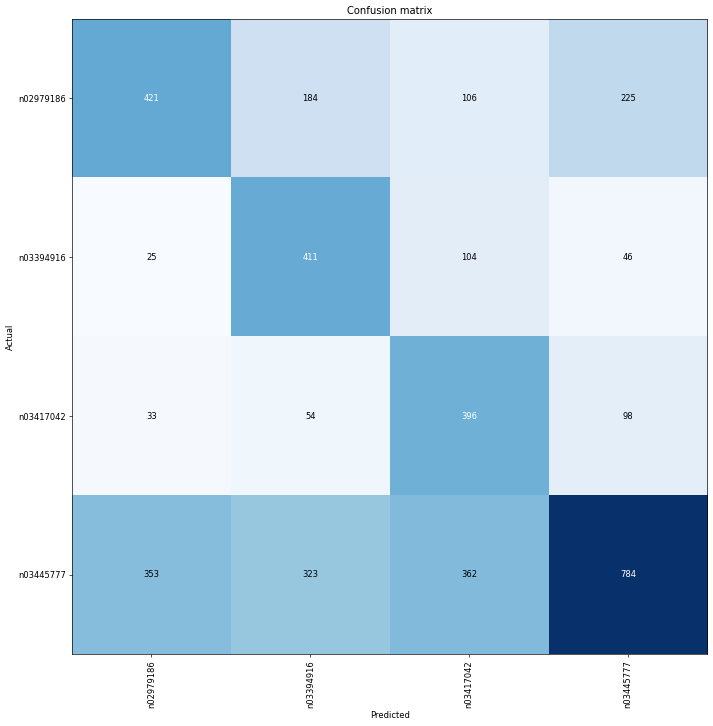

In [ ]:
# confusion_matrix for known, unknown and unseen categories
interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.save('bce-loss')

# 2. Train - BCE with Na category 

Here I have added "#na#" category and trained network with additional pictures from unknown categories.<br>
Loss function remains the same.

<small>I have also added <b>accuracy_with_na</b> and <b>accuracy_without_na</b> to compare accuracies with and without unknown pictures</small>

epoch,train_loss,valid_loss,accuracy,accuracy_without_na,accuracy_with_na,time
0,0.700357,0.447286,0.695780,0.675763,0.696881,00:26
1,0.377564,0.267287,0.719633,0.669916,0.719633,00:26


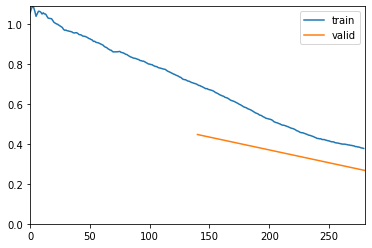

epoch,train_loss,valid_loss,accuracy,accuracy_without_na,accuracy_with_na,time
0,0.293345,0.242895,0.753394,0.660169,0.743853,00:26
1,0.277250,0.246992,0.746422,0.672515,0.733578,00:26
2,0.259057,0.229360,0.768807,0.690708,0.762202,00:27
3,0.251829,0.223348,0.771009,0.660169,0.763670,00:26
4,0.240420,0.220364,0.782752,0.717349,0.774312,00:26
5,0.216604,0.225114,0.779450,0.658869,0.765872,00:26
6,0.203013,0.198350,0.805138,0.706303,0.801835,00:27
7,0.185076,0.178506,0.823119,0.766732,0.823853,00:26
8,0.172457,0.172496,0.825321,0.749188,0.820550,00:27
9,0.164428,0.171805,0.834128,0.794672,0.830459,00:27


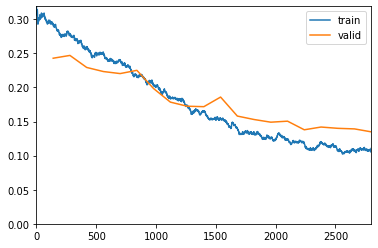

In [ ]:
learn = cnn_learner(
  get_train_dls(add_na=True), xresnet18, pretrained=True,
  loss_func=BCEWithLogitsLossOneHotFlat(),
  metrics=[accuracy, accuracy_without_na, accuracy_with_na],
  path=path,
  cbs=[ShowGraphCallback]
)

if torch.cuda.is_available(): learn = learn.to_fp16()

learn.fine_tune(20, freeze_epochs=2)

# Validate - BCE with Na category

After adding na category network have much better accuracy for known and unknown categories.

Accuracy is 87% for known and unknown categories.

But still, if picture is not simmilar to any seen pictures (even this trained as unknown category) <br> it tends to fall between one of five categories. Not always to first unknown category.

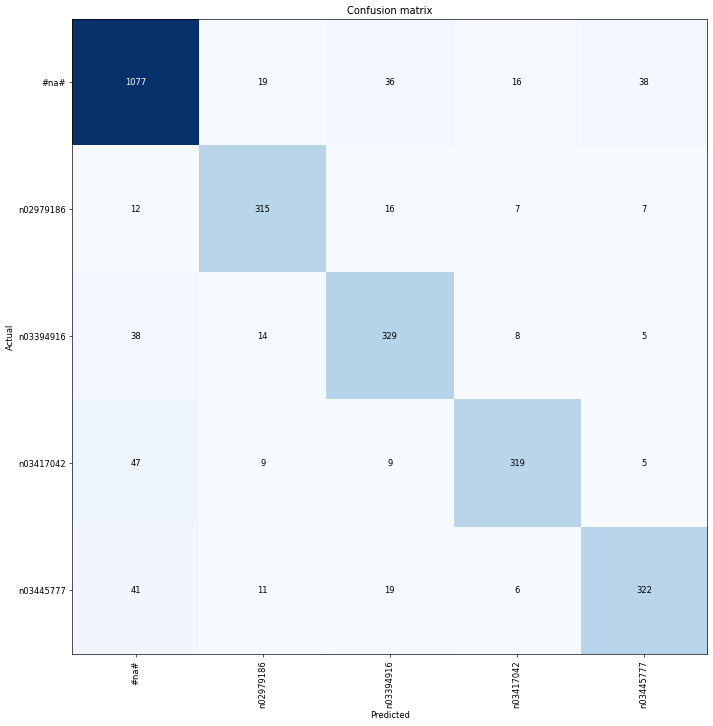

In [ ]:
# confusion_matrix for known and unknown categories
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.remove_cb(ShowGraphCallback) # fix fastai callback error during validation
mets = learn.validate(dl=learn.dls.test) # validate with all known, unknown and unseen categories

print(f'validation loss: {mets[0]}, accuracy: {mets[1]}, accuracy without na: {mets[2]}, [accuracy with n1]: {mets[3]}')

validation loss: 0.27719080448150635, accuracy: 0.7263694405555725, accuracy without na: 0.8349577784538269, [accuracy with n1]: 0.7597452402114868


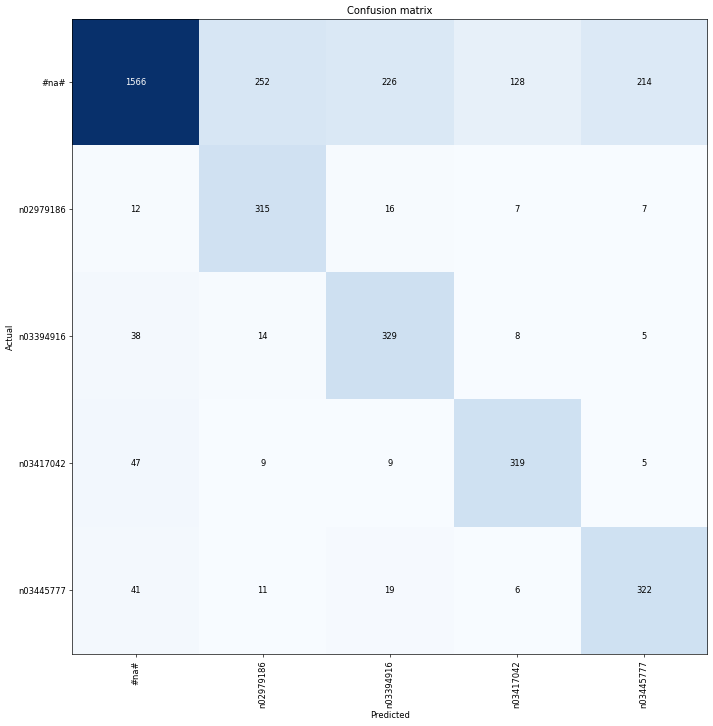

In [ ]:
# confusion_matrix for known, unknown and unseen categories
interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.save('bce-loss_with_na')

# 3. Train - BCENaLoss with Na as unknown category

I have trained network with adjusted BCENa loss which takes into account that picture <br>may not fall into any category.

<br>
<small>note that basic <b>accuracy</b> is much lower now, because it does not take into account that network may<br> not select any of the categories, but <b>accuracy_with_na</b> and <b>accuracy_without_na</b> which are taking are high</small>

epoch,train_loss,valid_loss,accuracy,accuracy_without_na,accuracy_with_na,time
0,0.720366,0.409573,0.521835,0.725146,0.588257,00:26
1,0.301052,0.175595,0.453578,0.803119,0.725872,00:26


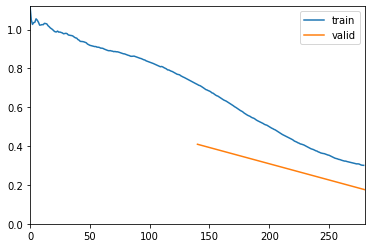

epoch,train_loss,valid_loss,accuracy,accuracy_without_na,accuracy_with_na,time
0,0.195266,0.159507,0.466789,0.826511,0.757064,00:27
1,0.181082,0.154998,0.473761,0.838856,0.763303,00:27
2,0.181440,0.147280,0.478165,0.846654,0.771009,00:27
3,0.165018,0.146036,0.475963,0.842755,0.775046,00:27
4,0.158038,0.144104,0.477431,0.845354,0.780550,00:27
5,0.148439,0.129429,0.480734,0.851202,0.801101,00:27
6,0.141616,0.133278,0.484404,0.857700,0.801468,00:27
7,0.134773,0.127924,0.483670,0.856400,0.804037,00:27
8,0.125629,0.127434,0.492844,0.872645,0.809541,00:27
9,0.117209,0.117377,0.495413,0.877193,0.820184,00:27


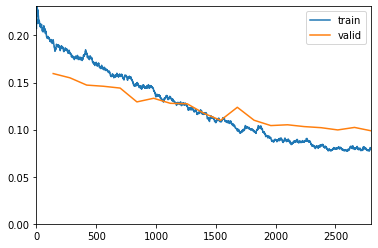

In [ ]:
learn = cnn_learner(
  get_train_dls(add_na=True), xresnet18, pretrained=True,
  loss_func=BCENaLossFlat(),
  metrics=[accuracy, accuracy_without_na, accuracy_with_na],
  path=path,
  cbs=[ShowGraphCallback]
)

if torch.cuda.is_available(): learn = learn.to_fp16()

learn.fine_tune(20, freeze_epochs=2)

# Validate - BCENaLoss with Na as unknown category

Accuracies goes up. It is good but it is not so relevant. More important is that pictures <br>from unseen categories more often than before fall into the #na# category.

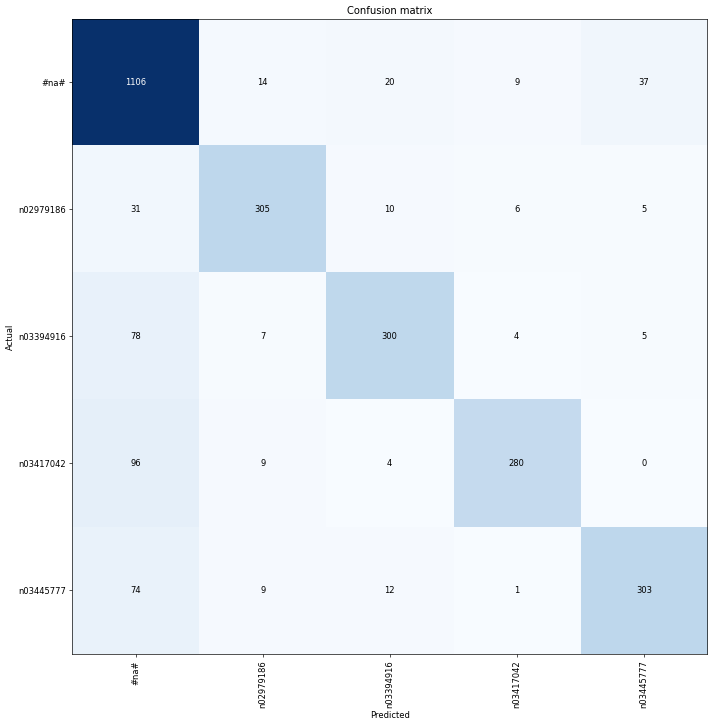

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.remove_cb(ShowGraphCallback) # fix fastai callback error during validation
mets = learn.validate(dl=learn.dls.test) # validate with all known, unknown and unseen categories

print(f'validation loss: {mets[0]}, accuracy: {mets[1]}, accuracy without na: {mets[2]}, [accuracy with n1]: {mets[3]}')

validation loss: 0.13276086747646332, accuracy: 0.3523567020893097, accuracy without na: 0.8986355066299438, [accuracy with n1]: 0.7449681758880615


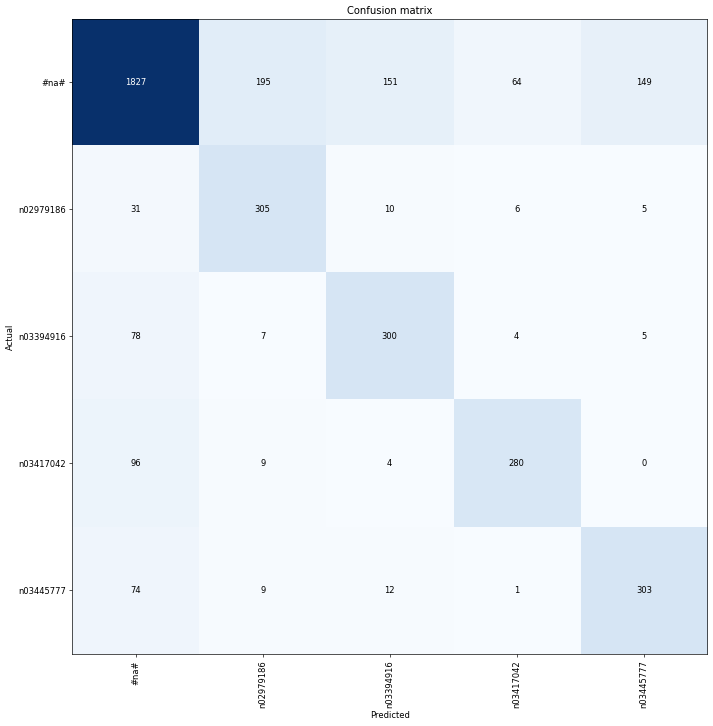

In [ ]:
# confusion_matrix for known, unknown and unseen categories
interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.save('bce-na-loss_with_na')

# Comparison

In [ ]:
# function to print and compare above experiments 
def validate_experiment(add_na=False, bcena=False):

  # get learner
  loss_func = BCENaLossFlat() if bcena else BCEWithLogitsLossOneHotFlat()
  metrics = [accuracy, accuracy_with_na, accuracy_without_na] if add_na else [accuracy]

  learn = cnn_learner(
    get_train_dls(add_na=add_na), xresnet18, pretrained=True,
    loss_func=loss_func,
    metrics=metrics,
    path=path
  )

  if not add_na and not bcena: lpath = 'bce-loss'
  if add_na and not bcena:     lpath = 'bce-loss_with_na'
  if add_na and bcena:         lpath = 'bce-na-loss_with_na'
  learn = learn.load(lpath)

  if torch.cuda.is_available(): learn = learn.to_fp16()

  # validate without na
  dls = get_train_dls(add_na=add_na, train_na=False)
  interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)
  d,t = flatten_check(interp.decoded, interp.targs)
  known_tp = (d==t).long().sum()

  # validate with na
  interp = ClassificationInterpretation.from_learner(learn, dl=learn.dls.test)
  d,t = flatten_check(interp.decoded, interp.targs)
  mets = learn.final_record
  acc = mets[-1]

  if add_na:
    i = t==0
    j = d==0
    unknown_tp = (d[i]==t[i]).long().sum()  # unknown true positive
    unknown_fn = (d[i]!=t[i]).long().sum()  # unknown false negative
    unknown_fp = (d[j]!=t[j]).long().sum()  # unknown false positive
  else:
    unknown_tp = 0
    unknown_fn = 2386 # all unknown pictures are false negative here
    unknown_fp = 0

  pr = f'{lpath:^20} => known TP: {known_tp:4d} | #na# TP: {unknown_tp:4d} | #na# FN: {unknown_fn:4d} | #na# FP: {unknown_fp:4d} | accuracy: {acc:2.4f}'

  print(pr)

In [ ]:
validate_experiment()
validate_experiment(add_na=True)
validate_experiment(add_na=True, bcena=True)

      bce-loss       => known TP: 1365 | #na# TP:    0 | #na# FN: 2386 | #na# FP:    0 | accuracy: 0.5090


  bce-loss_with_na   => known TP: 1285 | #na# TP: 1566 | #na# FN:  820 | #na# FP:  138 | accuracy: 0.8350


bce-na-loss_with_na  => known TP: 1188 | #na# TP: 1827 | #na# FN:  559 | #na# FP:  279 | accuracy: 0.8986


Definitely not adding additional category as "unknown" is just self-deception.

BCENa modification had increased number of correctly classified categories<br> that were unseen before and total accuracy is bigger after all.

<br>
TODO: Figure why number of correctly classified known categories is a bit lower? 
